In [1]:
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from numpy.random import rand,randint
import scipy.ndimage
from scipy.sparse import csr_matrix
import json
import matplotlib.pyplot as plt
import queue
import functools
import pandas

In [2]:
RANDOM_SEED = 42
cluster_number = 256
weights = rand(300,784)

### Clustering

In [3]:
def reshape_weights_for_kmeans(weights):
    return np.hstack(weights).reshape(-1,1)

def build_clusters(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED)
    kmeans.fit(reshape_weights_for_kmeans(weights))
    return kmeans.cluster_centers_

In [4]:
def nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    return (np.abs(centers - value)).argmin()

def nearest_centroid(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return centers[idx]

### Matrix

In [5]:
def redefine_weights(weights,centers):
    arr_ret = np.empty_like(weights).astype(np.int16)
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            arr_ret[i,j] = nearest_centroid_index(centers,weights[i,j])
    return arr_ret

In [6]:
def idx_matrix_to_matrix(idx_matrix,centers,shape):
    return centers[idx_matrix.reshape(-1,1)].reshape(shape)

In [7]:
def centroid_gradient_matrix(idx_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_matrix,index=range(cluster))

### Dictionary

In [8]:
# map (i,j) -> k
def dict_index_to_cluster(weights,centers):
        dict_ret = {}
        for i, row in enumerate(weights):
            for j, col in enumerate(row):
                dict_ret[(i,j)] = nearest_centroid_index(centers,weights[i,j])
        return dict_ret

# map k -> (i,j)
def dict_cluster_to_index(dict_idx):
    dict_ret = {}
    for k,v in dict_idx.items():
        if v in dict_ret:
            dict_ret[v] += [k]
        else:
            dict_ret[v] = [k]
    return dict_ret

In [9]:
def index_dict_to_matrix(dict_index,dict_values,shape):
    coord_array = np.asarray(list(dict_index.values()))
    return dict_values[coord_array].reshape(shape)

In [10]:
def centroid_gradient_dict(K_Index,W_Matrix):
    tmpindex = dict((key, ([x for x, _ in value], [y for _, y in value])) for key, value in K_Index.items())
    return [W_Matrix[value[0],value[1]].sum() for value in tmpindex.values()]

### Variables

In [11]:
centers = build_clusters(cluster_number,weights)
dict_index = dict_index_to_cluster(weights,centers)
dict_cluster = dict_cluster_to_index(dict_index)
matrix_index = redefine_weights(weights,centers)

### Testing

In [12]:
%timeit idx_matrix_to_matrix(matrix_index,centers,(300,784))
%timeit index_dict_to_matrix(dict_index,centers,(300,784))

642 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
16.9 ms ± 73.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit centroid_gradient_matrix(matrix_index,weights,cluster_number)
%timeit centroid_gradient_dict(dict_cluster,weights)

1.52 ms ± 8.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
80.9 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Transform

In [14]:
def dict_to_index_matrix_slow(dict_cluster):
    arr_ret = np.zeros((300,785))
    for k,v in dict_cluster.items():
        for i in v:
            arr_ret[i] = k
    return arr_ret

def dict_to_index_matrix(dict_index,shape):
    return np.asarray(list(dict_index.values())).reshape(shape).astype(np.int16)

In [15]:
%timeit dict_to_index_matrix_slow(dict_cluster)
%timeit dict_to_index_matrix(dict_index,(300,784))

49.8 ms ± 995 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
16.4 ms ± 56.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# HELPER FUNCTION

#### Cluster mean

In [17]:
def mean_distance(weights,centroids):
    tot = 0.
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            weight = weights[i,j]
            centroid = nearest_centroid(centroids,weight)[0]
            tot += np.sqrt((weight - centroid)**2)
    return tot / ((i+1)*(j+1))

In [18]:
def find_clusters_number(values,n_from,n_to,n_jump):
    result = {}
    for i in range(n_from,n_to+1,n_jump):
        kmeans = MiniBatchKMeans(n_clusters=i,random_state=RANDOM_SEED)
        kmeans.fit(reshape_weights_for_kmeans(values))
        mean = mean_distance(values,kmeans.cluster_centers_)
        result[i] = mean
        print("Mean for %s clusters %f " % (str(i).zfill(3),mean))
    return result
        
means_cluster_1_10 = find_clusters_number(weights,1,101,10)

Mean for 001 clusters 0.250563 
Mean for 011 clusters 0.022781 
Mean for 021 clusters 0.012038 
Mean for 031 clusters 0.008130 
Mean for 041 clusters 0.006277 
Mean for 051 clusters 0.005040 
Mean for 061 clusters 0.004181 
Mean for 071 clusters 0.003602 
Mean for 081 clusters 0.003128 
Mean for 091 clusters 0.002880 
Mean for 101 clusters 0.002646 


## Huffman Coding

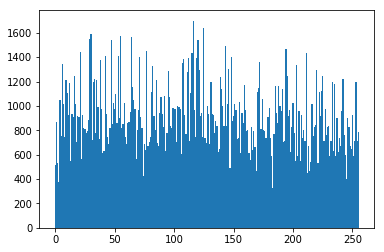

In [19]:
cluster_sparsity = [(len(dict_cluster[x]),x) for x in dict_cluster]
cluster_sparsity = sorted(cluster_sparsity, key=lambda x: x[0] )
plt.bar([x[1] for x in cluster_sparsity], [x[0] for x in cluster_sparsity], width=1)
plt.show()

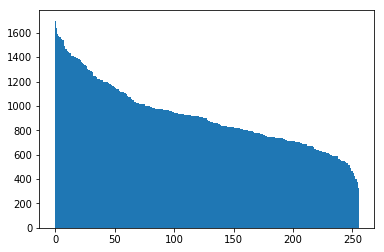

In [20]:
plt.bar(range(len(cluster_sparsity)), [x[0] for x in sorted(cluster_sparsity, key=lambda x: x[0], reverse=True)], width=1)
plt.show()

In [21]:
@functools.total_ordering
class HuffmanNode(object):
    def __init__(self, left=None, right=None):
        self.left = left
        self.right = right
    def children(self):
        return((self.left, self.right))
    def __lt__(self, other):
        return True

def create_tree(frequencies):
    p = queue.PriorityQueue()
    for value in frequencies:
        p.put(value)
    while p.qsize() > 1:
        l, r = p.get(), p.get()
        node = HuffmanNode(l, r)
        p.put((l[0]+r[0], node))    
    return p.get()

# Dictionary (n : "01010")
def coding_tree(node, prefix="", code={}):
    if isinstance(node[1].left[1], HuffmanNode):
        coding_tree(node[1].left,prefix+"0", code)
    else:
        code[node[1].left[1]]=prefix+"0"
    if isinstance(node[1].right[1],HuffmanNode):
        coding_tree(node[1].right,prefix+"1", code)
    else:
        code[node[1].right[1]]=prefix+"1"
    return(code)

def decode(rev_huff,code):
    for k, v in rev_huff.items():
        if v == code:
            return k
        
def encode(rev_huff,code):
    return rev_huff[code]

# Dictionary ("01010" : n)
def reverse_code(huff):
    huff_code_rev = {}    
    for k,v in huff.items():
        huff_code_rev[v] = k
    return huff_code_rev

def rev_encode(rev_huff,code):
    return decode(rev_huff,code)
        
def rev_decode(rev_huff,code):
    return encode(rev_huff,code)

In [22]:
cluster_sparsity = [(len(v),k) for k,v in dict_cluster.items()]
ht_cluster = create_tree(cluster_sparsity)
hc_cluster = coding_tree(ht_cluster,code={})
hc_rev = reverse_code(hc_cluster)

In [23]:
def nearest_centroid_index_huffman(centers,value):
    centers = np.asarray(centers)
    idx = (np.abs(centers - value)).argmin()
    return encode(hc_cluster,idx)

def redefine_weights_huffman(weights,centers):
    arr_ret = np.empty_like(weights).astype(str)
    for i, row in enumerate(weights):
        for j, col in enumerate(row):
            arr_ret[i,j] = nearest_centroid_index_huffman(centers,weights[i,j])
    return arr_ret

def dict_index_to_cluster_huffman(weights,centers):
        dict_ret = {}
        for i, row in enumerate(weights):
            for j, col in enumerate(row):
                dict_ret[(i,j)] = nearest_centroid_index_huffman(centers,weights[i,j])
        return dict_ret
    
def index_dict_to_matrix_huffman(dict_index,dict_values,huff_code,shape):
    coord_array = np.asarray([rev_decode(huff_code,x) for x in huff_dict_index.values()])
    return dict_values[coord_array].reshape(shape)

def centroid_gradient_matrix_huffman(idx_huff_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_huff_matrix,[x for x in cluster.values()])

huff_index_matrix = redefine_weights_huffman(weights,centers)
huff_dict_index = dict_index_to_cluster_huffman(weights,centers)

In [24]:
%timeit index_dict_to_matrix(dict_index,centers,(300,784))
%timeit index_dict_to_matrix_huffman(huff_dict_index,centers,hc_rev,(300,784))

17.9 ms ± 344 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
57.3 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%timeit centroid_gradient_matrix(matrix_index,weights,cluster_number)
%timeit centroid_gradient_matrix_huffman(huff_index_matrix,weights,hc_cluster)

1.28 ms ± 28.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
110 ms ± 1.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## PRUNING (with kmeans support)

In [72]:
def pruning_matrix(mat,percentage,method='out'):
    threshold = (100-percentage)
    
    if method == 'inout':
        threshold /= 4
        perc_up,perc_down,perc_mid_up,perc_mid_down = 100 - threshold, threshold, 50 + threshold, 50 - threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        percentile_mid_up = np.percentile(mat,perc_mid_up)
        percentile_mid_down = np.percentile(mat,perc_mid_down)
    else:
        threshold /= 2
        if method == 'in': perc_up, perc_down = 50 + threshold, 50 - threshold
        elif method == 'out': perc_up, perc_down = 100 - threshold, threshold
        percentile_up = np.percentile(mat,perc_up)
        percentile_down = np.percentile(mat,perc_down)
        
    w_pruned = np.copy(mat)
    for i,row in enumerate(mat):
        for j,_ in enumerate(row):
            if method == 'in':
                if mat[i,j] > percentile_down and mat[i,j] < percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'out':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up:
                    w_pruned[i,j] = 0
            elif method == 'inout':
                if mat[i,j] < percentile_down or mat[i,j] > percentile_up or (mat[i,j] > percentile_mid_down and mat[i,j] < percentile_mid_up):
                    w_pruned[i,j] = 0
    return csr_matrix(w_pruned)

In [75]:
w_csr = pruning_matrix(weights,70,method='inout')
len(w_csr.nonzero()[0])/(300*784)

0.7

In [37]:
def P_build_clusters(cluster,weights):
    kmeans = MiniBatchKMeans(n_clusters=cluster,random_state=RANDOM_SEED)
    kmeans.fit(weights.data.reshape(-1,1))
    return kmeans.cluster_centers_

P_centers = P_build_clusters(256,w_csr)

In [38]:
def P_nearest_centroid_index(centers,value):
    centers = np.asarray(centers)
    return (np.abs(centers - value)).argmin()

In [39]:
def P_redefine_weights(weights,centers):
    csr_idx = weights.copy()
    arr_ret = np.empty_like(csr_idx.data).astype(np.int16)
    for i,w in enumerate(csr_idx.data):
        arr_ret[i] = P_nearest_centroid_index(centers,w)
    csr_idx.data = arr_ret
    return csr_idx

idx_csr = P_redefine_weights(w_csr,P_centers)

In [40]:
def P_idx_matrix_to_matrix(idx_matrix,centers):
    w_csr = idx_matrix.copy()
    w_csr.data = centers[w_csr.data]
    return w_csr

%timeit P_idx_matrix_to_matrix(idx_csr,P_centers)

450 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
def P_centroid_gradient_matrix(idx_matrix,gradient,cluster):
    return scipy.ndimage.sum(gradient,idx_matrix.todense(),index=range(cluster))

%timeit P_centroid_gradient_matrix(idx_csr,weights[0],256)

1.59 ms ± 47 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
